# Reference Path Processing

Curvilinear coordinate frames are heavily influenced by the quality of the reference path (in our case a 2d polyline). Potential issues of the reference path are for example discontinuities, insufficient smoothness or noisy profiles of the curvature (rate), too high curvature values, oversampling etc... This can lead to a variety of problems when using the curvilinear representation for downstream tasks (e.g., motion planning), such as discontinuous trajectories, infeasibilities, arbitrary projections etc...

Therefore, we provide different methods which can be used to pre-process the reference path w.r.t. the aforementioned issues. Here, we show some examples.

### Load scenario and get initial reference path 

Load scenario

In [1]:
import os
from commonroad.common.file_reader import CommonRoadFileReader

# Load scenario
scenario_name = 'ZAM_Tjunction-1_42_T-1.xml'
file_path = os.path.join(os.getcwd(), "../", scenario_name)
scenario, planning_problem_set = CommonRoadFileReader(file_path).open()
planning_problem = list(planning_problem_set.planning_problem_dict.values())[0]

Plan initial reference path

In [2]:
from commonroad_route_planner.route_planner import RoutePlanner
from commonroad_route_planner.reference_path_planner import ReferencePathPlanner
from copy import deepcopy

# Plan initial reference path
routes = RoutePlanner(scenario.lanelet_network, planning_problem).plan_routes()
ref_path = ReferencePathPlanner(
    lanelet_network=scenario.lanelet_network,
    planning_problem=planning_problem,
    routes=routes
).plan_shortest_reference_path().reference_path

# store original reference path
ref_path_original = deepcopy(ref_path)

Running cmake --build & --install in /home/gerald/Documents/CommonRoad/cps/commonroad-clcs/build/Release_cp311-cp311-manylinux_2_31_x86_64


Initialize parameter object

In [3]:
from commonroad_clcs.config import (
    CLCSParams,
    ProcessingOption,
    ResamplingOption
)

# initialize CLCS params
params = CLCSParams()

### Extend reference path

To avoid errors for motion planning near the start and ends of the reference path, we can extend the original path by a fixed length front/back. It is extended by adding the centerpoints of predecessor/successor lanelets (if available) or by linear extrapolation.

In [4]:
from commonroad_clcs.helper.smoothing import smooth_polyline_rdp

# first remove noisy points via RDP polyline simplification and resample the path
ref_path = smooth_polyline_rdp(
    polyline = ref_path,
    resample_step = 1.0
)

In [5]:
from commonroad_clcs.util import extend_reference_path

# extend reference path
ref_path = extend_reference_path(
        reference_path=ref_path,
        resample_step=1.0,
        extend_front_length=10.0,
        extend_back_length=5.0,
        lanelet_network=scenario.lanelet_network
    )

In [6]:
from commonroad_clcs.util import compute_polyline_length

# compare lengths before/after
print(f"Length before extension: {compute_polyline_length(ref_path_original)}")
print(f"Length after extension: {compute_polyline_length(ref_path)}")

Length before extension: 347.4824591460011
Length after extension: 362.47251851872124


### Pre-processing options

Below we show a few exemplary reference path processing methods which can be used depending on the use-case. See `commonroad_clcs/ref_path_processing` for more available methods.

To simplify the usage, the pre-processing options can be used via a unified interface `IReferencePathProcessor`. The pre-processing options can be configured via the `CLCSParams()` objects

#### Resampling options

The reference path can either be sampled with a fixed sampling distance or an adaptive sampling distance. In the latter case, the density of points is increased in parts where the curvature is higher and lower curvature parts are sampled coarsely to reduce number of points without losing accuracy.

In [7]:
# resampling settings
params.resampling.option = ResamplingOption.ADAPTIVE
params.resampling.min_step = 0.4
params.resampling.max_step = 2.0

#### Smooth via Spline Smoothing

We first show an example how to smooth the reference path by approximating it using simple smoothing B-splines which smooths jerky curvature (rate) profiles.

In [8]:
from commonroad_clcs.ref_path_processing.factory import ProcessorFactory

# spline smoothing settings
params.processing_option = ProcessingOption.SPLINE_SMOOTHING
params.spline.degree_spline = 3
params.spline.smoothing_factor = 2.0

# process reference path
ref_path_processor = ProcessorFactory.create_processor(params)
ref_path_spline = ref_path_processor(ref_path)

#### Smooth via Curve Subdivision

Here, we show how to pre-process the reference path using an iterative curve subdivision and also limit the curvature to a desired value

In [9]:
# curve subdivision settings
params.processing_option = ProcessingOption.CURVE_SUBDIVISION
params.subdivision.degree = 2
params.subdivision.num_refinements = 3
params.subdivision.coarse_resampling_step = 2.0
params.subdivision.max_curvature = 0.12

# process reference path
ref_path_processor = ProcessorFactory.create_processor(params)
ref_path_cs = ref_path_processor(ref_path)

### Evaluation

We inspect and compare the smoothness (curvature and curvature rate) of the paths compared to the original reference path

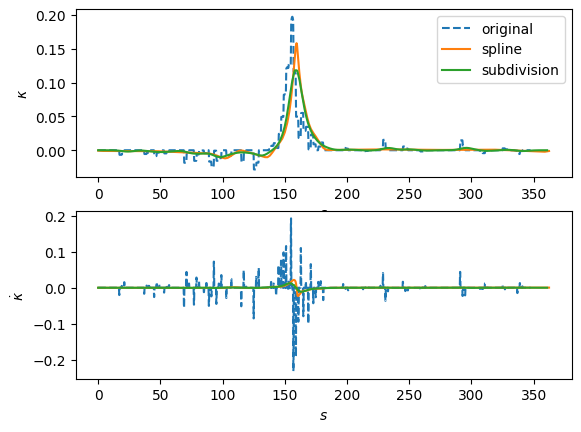

In [10]:
from matplotlib import pyplot as plt
from commonroad_clcs.helper.evaluation import plot_ref_path_curvature

# create fig
fig, axs = plt.subplots(2)
# plot curvatures
plot_ref_path_curvature(ref_path_original, axs=axs, label="original", linestyle="dashed")
plot_ref_path_curvature(ref_path_spline, axs=axs, label="spline")
plot_ref_path_curvature(ref_path_cs, axs=axs, label="subdivision")